In [1]:
# Load Data
%%bash
pip install pyspark
# Download the data files from github
# If the data file does not exist in the colab environment
if [[ ! -f ./players_20.csv ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/Kun97/FIFA20_DataAnalysis/main/players_20.csv
fi

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=37e888bacc60ff8a7e893247fc4cca5ef22395b90dd2dfe5dbd56f86045308e1
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


--2020-11-29 06:40:37--  https://raw.githubusercontent.com/Kun97/FIFA20_DataAnalysis/main/players_20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8945067 (8.5M) [text/plain]
Saving to: ‘players_20.csv’

     0K .......... .......... .......... .......... ..........  0% 3.86M 2s
    50K .......... .......... .......... .......... ..........  1% 11.7M 1s
   100K .......... .......... .......... .......... ..........  1% 4.38M 2s
   150K .......... .......... .......... .......... ..........  2% 15.6M 1s
   200K .......... .......... .......... .......... ..........  2% 6.66M 1s
   250K .......... .......... .......... .......... ..........  3% 28.9M 1s
   300K .......... .......... .......... .......... ..........  4% 29.0M 1s
   350K .......... .......... .

In [134]:
# The first code cell of your notebook shall include all needed imports to run your project code.  Note that
# there can be markdown cells above this cell.
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import col, lit, split, isnan, when, count, isnull, udf, asc
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexerModel, StringIndexer, OneHotEncoder, StandardScaler, PCA, VectorAssembler
from matplotlib import pyplot as plt
import numpy as np
from pyspark.sql.types import FloatType
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

In [4]:
original_data = spark.read.csv("players_20.csv", inferSchema=True, header=True)

In [5]:
# drop useless columns
drop1_columns = ['sofifa_id', 'player_url', 'long_name', 'player_tags', 'player_traits', 'real_face', 'nation_jersey_number', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until']
fixed1_Data = original_data.drop(*drop1_columns)

In [6]:
# drop position ability(duplicated and will affect the final result)
drop2_columns = fixed1_Data.columns[-26:]
fixed2_Data = fixed1_Data.drop(*drop2_columns)

In [7]:
# drop duplicated columns
drop3_columns = ['wage_eur', 'team_position', 'release_clause_eur', 'nation_position', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
fixed3_Data = fixed2_Data.drop(*drop3_columns)

In [8]:
# split player_positions and choose the first position as primary position
split_col = split(fixed3_Data['player_positions'], ',')
position_data = fixed3_Data.withColumn('Position', split_col.getItem(0))
position_data = position_data.drop('player_positions')

In [9]:
# split work_Rate 
split_col = split(position_data['work_rate'], '/')
position_data = position_data.withColumn('Attack_workrate', split_col.getItem(0))
position_data = position_data.withColumn('Defend_workrate', split_col.getItem(1))
position_data = position_data.drop('work_rate')

In [10]:
# narrow down positions: defender
defender = ['LCB', 'RCB', 'LB', 'RB', 'CB', 'RWB', 'LWB']
defender_data = position_data.filter(col('Position').isin(defender)).withColumn('Positon_General', lit('Defender'))
defender_data.count()

5938

In [11]:
# midfileder
midfileder = ['LCM', 'LM', 'RDM', 'CAM', 'RAM', 'RCM', 'CM', 'CDM', 'RM', 'LAM', 'LDM']
midfileder_data = position_data.filter(col('Position').isin(midfileder)).withColumn('Positon_General', lit('Midfileder'))
midfileder_data.count()

6862

In [12]:
# attacker
attacker = ['ST', 'CF', 'LW', 'RW']
attacker_data = position_data.filter(col('Position').isin(attacker)).withColumn('Positon_General', lit('Attacker'))
attacker_data.count()

3442

In [13]:
# goal keeper
gk_data = position_data.filter(col('Position').isin(['GK'])).withColumn('Positon_General', lit('GK'))
gk_data.count()

2036

In [14]:
general_data = defender_data.union(midfileder_data).union(attacker_data).union(gk_data)

In [15]:
# missing values: 
general_data.select([count(when(isnull(c), c)).alias(c) for c in general_data.columns]).show()

+----------+---+---+---------+---------+-----------+----+-------+---------+---------+--------------+------------------------+---------+-----------+---------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+-----------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+--------+---------------+---------------+---------------+
|short_name|age|dob|height_cm|weight_kg|nationality|club|overall|potential|value_eur|preferred_foot|international_reputat

In [16]:
# duplicated values: general data
if general_data.count() == general_data.drop_duplicates().count():
  print('No duplicated records.')

No duplicated records.


In [17]:
# numerlize categorical data
# Rate: low, medium, high: 0, 1, 2
# foot: left, right: 1, 0
data_prepipe = Pipeline(stages=[
                                StringIndexerModel.from_labels(['Low', 'Medium', 'High'], inputCol='Attack_workrate', outputCol='Attack_workrate_num'),
                                StringIndexerModel.from_labels(['Low', 'Medium', 'High'], inputCol='Defend_workrate', outputCol='Defend_workrate_num'),
                                StringIndexer(inputCols=["preferred_foot", "body_type", "Positon_General"], outputCols=["preferred_foot_num", "body_type_num", "Positon_General_num"]),
                                OneHotEncoder(inputCols=['preferred_foot_num', 'body_type_num'], outputCols=['foot', 'body'])
])

In [18]:
general_data_xformed = data_prepipe.fit(general_data).transform(general_data)

In [19]:
general_data_xformed.show()

+---------------+---+----------+---------+---------+-----------+-------------------+-------+---------+---------+--------------+------------------------+---------+-----------+---------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+-----------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+--------+---------------+---------------+---------------+-------------------+-------------------+------------------+-------------+-------------------+--

In [118]:
# find out all columns we need for pca, clustering and recommender system
remove_columns = ['short_name', 'dob', 'nationality', 'club', 'preferred_foot', 'body_type', 'Position', 'Attack_workrate', 'Defend_workrate', 'Positon_General']
va_columns = list(set(general_data_xformed.columns) - set(remove_columns))

In [119]:
# vector assemble and standardization
recommender_va = VectorAssembler(inputCols=va_columns, outputCol='feature')

In [120]:
standardization = StandardScaler(withMean=True, withStd=True, inputCol='feature', outputCol='std_feature')

In [121]:
# check number of pca we need
# According to ISLR, "There are at most min(n - 1; p) principal components" where n is the number of rows, 18278 and p is the number of cols, 7408.
min(recommender_std_data.count()-1, len(va_columns))

50

In [42]:
pca = PCA(k=50, inputCol='std_feature', outputCol='scores')

In [55]:
# create pipeline for all above transformation
pca_pipe = Pipeline(stages=[recommender_va, standardization, pca]).fit(general_data_xformed)
pca_data = recommender_pipe.transform(general_data_xformed)

In [50]:
# account for 99% variance of original data
sum(pca_pipe.stages[-1].explainedVariance)

0.997485031668349

Text(0, 0.5, 'Proportion Variance Explained')

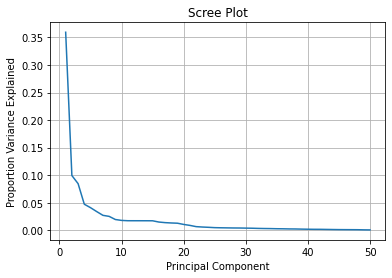

In [52]:
plt.figure()
explained_var = pca_pipe.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.grid(True)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

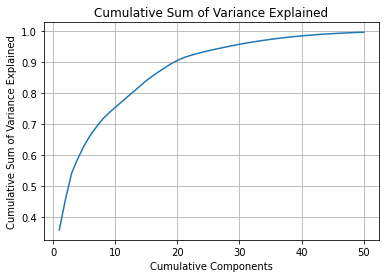

In [53]:
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.grid(True)
plt.title("Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

In [54]:
# I choose 30 pca

In [122]:
# recommender system
recommender_pca = PCA(k=2, inputCol='std_feature', outputCol='scores')
recommender_pipe = Pipeline(stages=[recommender_va, standardization, recommender_pca]).fit(general_data_xformed)
recommender_data = recommender_pipe.transform(general_data_xformed)

In [62]:
def l2_dist(c1, c2):    
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))

l2_dist_udf = udf(l2_dist, FloatType())

In [65]:
def recommender_system(name, num_players):
  try:
    cha = list([name])
    num = int(num_players)
  except:
    return 'Check your inputs!'

  condition = (col('short_name') == cha[0])

  length_check = (len(cha) == 1)
  exist_check = recommender_data.where(condition).count() !=0

  if length_check & exist_check:
    
    result_df = recommender_data.where(condition).select(col("scores").alias('target_scores')).join(recommender_data).withColumn('dist', l2_dist_udf('scores', 'target_scores')).\
    select("short_name", "overall", "Position", 'value_eur',"dist").\
    orderBy(asc("dist")).\
    limit(num+1)

    result = result_df.select('short_name').rdd.map(lambda x: x['short_name']).collect()
    result.remove(cha[0])
  else:
    return 'Check your inputs!'
  
  return result_df.show()

In [76]:
recommender_system('L. Messi',5)

+-----------------+-------+--------+---------+---------+
|       short_name|overall|Position|value_eur|     dist|
+-----------------+-------+--------+---------+---------+
|         L. Messi|     94|      RW| 95500000|      0.0|
|        Neymar Jr|     92|      LW|105500000|1.1863747|
|         M. Salah|     90|      RW| 80500000|2.0420809|
|Cristiano Ronaldo|     93|      ST| 58500000|2.1899347|
|        E. Hazard|     91|      LW| 90000000|2.4917612|
|          M. Reus|     88|     CAM| 56000000| 3.112555|
+-----------------+-------+--------+---------+---------+



In [77]:
recommender_system('Cristiano Ronaldo',5)

+-----------------+-------+--------+---------+----------+
|       short_name|overall|Position|value_eur|      dist|
+-----------------+-------+--------+---------+----------+
|Cristiano Ronaldo|     93|      ST| 58500000|       0.0|
|        E. Hazard|     91|      LW| 90000000| 0.6443591|
|         M. Salah|     90|      RW| 80500000|0.77271783|
|          M. Reus|     88|     CAM| 56000000| 1.1080582|
|        K. Mbappé|     89|      ST| 93500000| 1.1468645|
|        P. Dybala|     88|     CAM| 76500000| 1.3540837|
+-----------------+-------+--------+---------+----------+



In [78]:
recommender_system('J. Oblak',5)

+-------------+-------+--------+---------+----------+
|   short_name|overall|Position|value_eur|      dist|
+-------------+-------+--------+---------+----------+
|     J. Oblak|     91|      GK| 77500000|       0.0|
|M. ter Stegen|     90|      GK| 67500000|  0.442823|
|      Alisson|     89|      GK| 58000000|0.63506997|
|    N. Guzmán|     79|      GK|  7000000| 0.6930314|
|     M. Neuer|     88|      GK| 32000000|0.79718935|
|    Z. Zlámal|     65|      GK|   290000|0.95787865|
+-------------+-------+--------+---------+----------+



In [79]:
recommender_system('V. van Dijk',5)

+-------------+-------+--------+---------+---------+
|   short_name|overall|Position|value_eur|     dist|
+-------------+-------+--------+---------+---------+
|  V. van Dijk|     90|      CB| 78000000|      0.0|
|   L. Bonucci|     86|      CB| 28500000|0.8356908|
| Thiago Silva|     87|      CB| 18500000| 0.845975|
|   M. Hummels|     87|      CB| 41000000|0.8893796|
|J. Vertonghen|     87|      CB| 32500000|0.9948709|
|   A. Laporte|     87|      CB| 56500000|1.0277069|
+-------------+-------+--------+---------+---------+



In [80]:
recommender_system('K. De Bruyne',5)

+---------------+-------+--------+---------+---------+
|     short_name|overall|Position|value_eur|     dist|
+---------------+-------+--------+---------+---------+
|   K. De Bruyne|     91|     CAM| 90000000|      0.0|
|      L. Modrić|     90|      CM| 45000000|0.6878779|
|   A. Griezmann|     89|      CF| 69000000|0.8779534|
|        Marcelo|     85|      LB| 28000000|1.4717091|
|Bruno Fernandes|     85|     CAM| 49000000|1.5002266|
|         Thiago|     87|      CM| 50000000|1.5272787|
+---------------+-------+--------+---------+---------+



In [71]:
# inference analysis
pca_model = recommender_pipe.stages[-1]

In [87]:
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc_loadings = pd.DataFrame([va_columns, np.abs(pc1)]).T.rename(columns={0: 'word', 1:'loading'})

In [88]:
most_imp_df = pc_loadings.sort_values('loading', ascending=False).head(10)
least_imp_df = pc_loadings.sort_values('loading', ascending=True).head(10)

In [89]:
display(most_imp_df)
display(least_imp_df)

,word,loading
44,attacking_volleys,0.210889
0,skill_dribbling,0.206001
51,NaN,0.202503
45,movement_agility,0.193173
25,attacking_crossing,0.19311
43,attacking_short_passing,0.189979
2,power_long_shots,0.188104
48,movement_reactions,0.180418
12,goalkeeping_reflexes,0.180373
1,goalkeeping_handling,0.180234


,word,loading
33,power_stamina,9.03917e-05
32,preferred_foot_num,0.00177895
35,skill_curve,0.00326117
38,skill_long_passing,0.00364911
34,mentality_vision,0.0037851
37,mentality_positioning,0.00414048
36,skill_ball_control,0.00427515
28,Defend_workrate_num,0.0114461
26,body_type_num,0.0183089
31,attacking_heading_accuracy,0.0199913


In [135]:
# K-Means
# best pca: 30
# recommender system
kmeans_pca = PCA(k=30, inputCol='std_feature', outputCol='scores')
kmeans_pipe = Pipeline(stages=[recommender_va, standardization, kmeans_pca]).fit(general_data_xformed)
kmeans_data = kmeans_pipe.transform(general_data_xformed)

In [136]:
km = KMeans(featuresCol='scores', predictionCol='Kmeans_feat')
evaluator = ClusteringEvaluator(featuresCol='scores', predictionCol='Kmeans_feat')

In [137]:
def max_silhouette(k):
  score = []
  for i in range(3):
    km.setK(k)
    km.setSeed(int(np.random.randint(100, size=1)))
    pred = km.fit(kmeans_data).transform(kmeans_data)
    score.append(evaluator.evaluate(pred))
  
  return max(score)


In [138]:
result = []
for i in range(2, 7):
  result.append(max_silhouette(i))

Text(0.5, 1.0, 'Silhouette Score vs Number of Clusters')

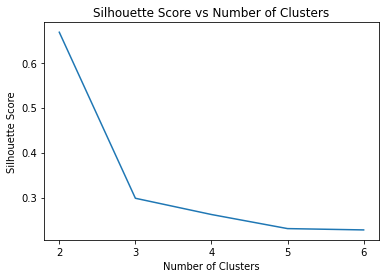

In [139]:
plt.plot(range(2,7), result)
plt.xticks(range(2,7))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')

In [141]:
final_km = KMeans(k=2 ,featuresCol='scores', predictionCol='Kmeans_feat')
final_data = final_km.fit(recommender_data).transform(recommender_data)

In [142]:
X = np.array(final_data.select('scores').rdd.map(lambda x: x['scores']).collect())
names = np.array(final_data.select('short_name').rdd.map(lambda x: x['short_name']).collect())

In [143]:
cluster = final_data.select('Kmeans_feat').collect()

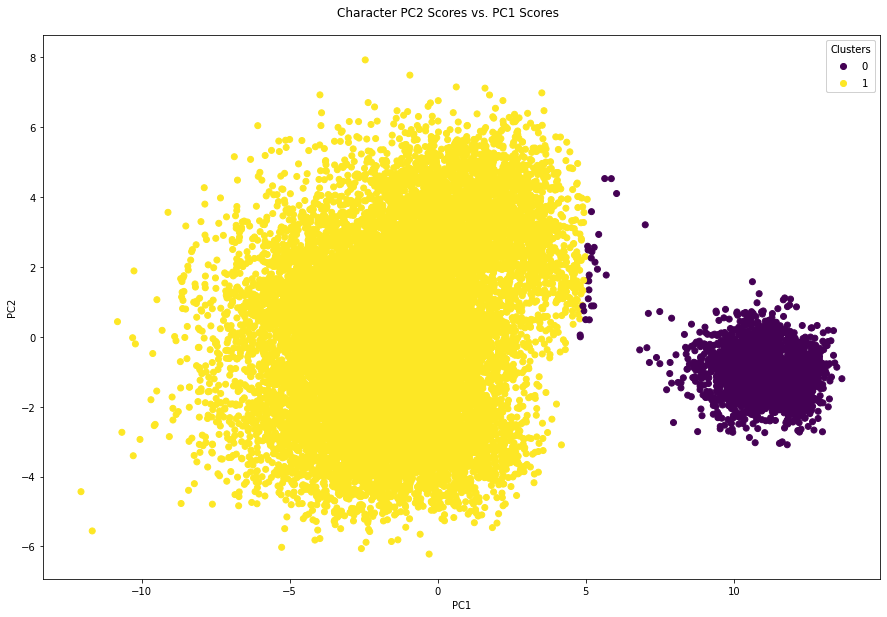

In [144]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
scatter = ax.scatter(X[:,0], X[:,1], c=cluster)
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)
fig.suptitle("PC2 Scores vs. PC1 Scores", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")  
plt.show()